In [17]:
import sys
sys.path.append('/home/yiftach/PycharmProjects/Survival-Analysis')
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
pd.options.display.max_seq_items = 200
from typing import List
import numpy as np
from copy import deepcopy
from etl.data_loading import get_df_for_stage
from etl.train_test_split import impute_nan_values_and_split_to_train_test
import config
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import as_integrated_brier_score_scorer, brier_score
from recursive_feature_elimination import get_features_using_rfe
from sklearn.model_selection import StratifiedKFold,GridSearchCV
SEED = 472

# Problem goal

to predict survival probabilities for patients in 3, 6, 12 and 24 months - in order to aid clinical decision making. 
We focus on these times, as they were derieved from the clinical decisions regarding the patient - mostly wheter to operate HIPEC or not. 

# Data Cleaning

we have a dataframe for each stage, pre, intra and post surgery.
we begin by cleaning the original data by removing mostly empty columns.
for each stage we have a different DataFrame representing the features available for us at that time. 
Lets look at those df's

In [3]:
print('Pre columns')
print(get_df_for_stage('pre',return_all_features = True).columns.to_list())
print('Intra surgery columns')
print(get_df_for_stage('intra',return_all_features = True).columns.to_list())
print('post surgery columns')
print(get_df_for_stage('post',return_all_features = True).columns.to_list())

Pre columns
['age', 'gender', 'weight', 'height', 'BMI', 'DM', 'HTN', 'Renal', 'IHD', 'COPD', 'obesity', 'Cva', 'asa', 'Tumor_origin', 'survival_time_in_months', 'death']
Intra surgery columns
['age', 'gender', 'weight', 'height', 'BMI', 'DM', 'HTN', 'Renal', 'IHD', 'COPD', 'obesity', 'Cva', 'asa', 'Tumor_origin', 'survival_time_in_months', 'death', 'hipec_carried_out', 'redo_hipec', 'extra_peritoneal___none', 'extra_peritoneal___liver', 'extra_peritoneal___pancreas', 'extra_peritoneal___rplnd', 'extra_peritoneal___pelvis', 'extra_peritoneal___groin', 'extra_peritoneal___abdominal_wall', 'critical_lesions', 'ascites_drained', 'anastomosis___sb_sb', 'anastomosis___gastro_sb', 'anastomosis___sb_colon', 'anastomosis___colon_colon', 'anastomosis___colon_rectum', 'anastomosis___sb_rectum', 'resections___colon', 'resections___sb', 'resections___anterior_resection', 'resections___spleen', 'resections___pancreas', 'resections___cholecystectomy', 'resections___cystectomy', 'resections___omentum

as you can see, we have a lot of features in the post and intra df!

In [4]:
print(get_df_for_stage('post',return_all_features = True).shape[1])

115


we dropped these columns as they were filled with mostly empty values, or suffered from other critical disadvantage we manually regarded.

In [5]:
print(config.FEATURES_TO_DROP)

['Primay pathology:', 'liver', 'complications___other', 'resections___none', 'anastomosis___none', 'complications___none', 'Gi leaks', 'Bleeding', 'Other', 'Death', 'complications___natropenia', 'complications___delirium', 'Gemzar', 'resections___appendix']


In [6]:
print(f'''We have {get_df_for_stage('post')['death'].sum()} deaths in our dataset''')

We have 38 deaths in our dataset


# Feature engineering

We have too many features compared to deaths. We will try and deal with this problem in 2 ways:
    1)Feature aggragations
    2)Feature Selection
Our goal will be to reach a model with about ~20 features instead of 120+.
`


We have made simple aggragative features - counting complications, resections and anastamoses.
we will check later if keeping only those aggragations is sufficient for good model performance. 


In [7]:
get_df_for_stage('post',return_all_features = True,keep_only_aggs=False)['resections_count']

0       6
1      12
2       2
3       7
4       4
       ..
209     1
210     0
211    10
212     1
213     2
Name: resections_count, Length: 212, dtype: int64

In [8]:
print(f"{get_df_for_stage('post',return_all_features = True,keep_only_aggs=False).shape[1]} columns without aggs")
print(f"{get_df_for_stage('post',return_all_features = True,keep_only_aggs=True).shape[1]} columns with aggs")

115 columns without aggs
68 columns with aggs


A utiliy function to filter DataFrame columns from a list

In [9]:
def filter_df_columns_from_list(df:pd.DataFrame,features_list:List[str]) -> pd.DataFrame:
    return df[df.columns.intersection(features_list)]

In [10]:
df = get_df_for_stage('post',return_all_features = True,keep_only_aggs=False)
filter_df_columns_from_list(df,['SPS','junk_column']).head(2)

,SPS
0,0
1,1


# Evaluation Metrics

Since we want to report Survival Probabilites in specific moments,
we choose the Brier Score as our evaluation metric - as it measures both calibration and precision/recall.
It's defined as mean(is_dead_at_time_t - survival prediction)^2. 
Our libraries use negative brier score (-1*brier) as it allows them to maximize rather than minimize. 

We will report concordance as well as it is well accepted in the literature but we believe it is not relevant for
our clinical purpose as we are not interested in rank, nor in a binary prediction.

A random model gives 0.25 brier score. 
Following Jensens Inequallity for concave functions, we know that
$\sqrt{Brier Score} >= mean(\sqrt{(label - precition)^2)}$.
Thus, a Brier score of 0.06 for example means that 

explanation:
    if we got a brier score of 0.06 than $mean((label-predX_train_validation == 0.06$.
    $\sqrt{Brier Score} >= mean(\sqrt{(label - precition)^2)} == mean(label-prediction)$,
    so that means that the mean difference between label and prediction is $\sqrt{0.06} =  0.25$.
    for a prediction of 0.8 probability of survival, the real survival prob should be between 0.6 and 1 (on the average case...)

# Cross Validation Method

We keep ~0.2 of our data aside as test, stratified on number of deaths. This is a bit problematic as we may have split of data with deaths occuring at very different time,
and our model is time specific. That means we can't take the test results for granted.
The dataset is too small to cope with such a problem, so we'll have to cross our fingers.

In [11]:
X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(get_df_for_stage('post',return_all_features=True),seed = SEED)
print(f"ratio between test and train size: {len(y_test)/len(y_train_validation)}")                                                                                                  

ratio between test and train size: 0.25443786982248523


On our Train_validate set, we report scores averaged on 3 kfolds. The folds are stratified based on their deaths counts
. 
from our death code validation function:


    'cv = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=SEED)
    indices = [x for x in cv.split(X,y['death'])]'

# Model Selection

We have ran many tests, which are recorded in our Weights And Biases space.
As obvious from this report, it is clear that Random Survival Forest gave the best scores in almost every dataset stage and time.
In this conclusive notebook we will not try out other algorithms.

note: We ran Deep models like MTLR and Deepsurv and got inferior results - BUT we havn't made hyperparameters search on these.
    So we can asses properly whether they would have been better. 
    

For Model Selection, we have made the following process:
    1. hyperparamter search over all the features - 
    2. Feature Selection based on chosen hyperparameters.
    3. Rigorous hyperparameters search with selected features.

Our application serves different model for each time and dataset stage, here we will look at Intra, 6 months. 

In [11]:
stage = 'intra'
time = 6

<iframe src="https://wandb.ai/survival_analysis/Survival-Analysis-models/reports/Shared-panel-21-11-04-00-11-25--VmlldzoxMTg1NzAz?highlightShare" style="border:none;height:200px;width:100%">

## Hyperparameter search over all features

as obvious from this plot, we have ran many models. We choose one of them, which is:

In [12]:
intra_6_rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10,min_samples_leaf=30)
#and lets add another gradient boosting for fun
intra_6_gbm = GradientBoostingSurvivalAnalysis(loss="coxph", learning_rate=0.05, n_estimators=1000,
                                           min_samples_split=5, min_samples_leaf=3, max_depth=3, random_state=0)

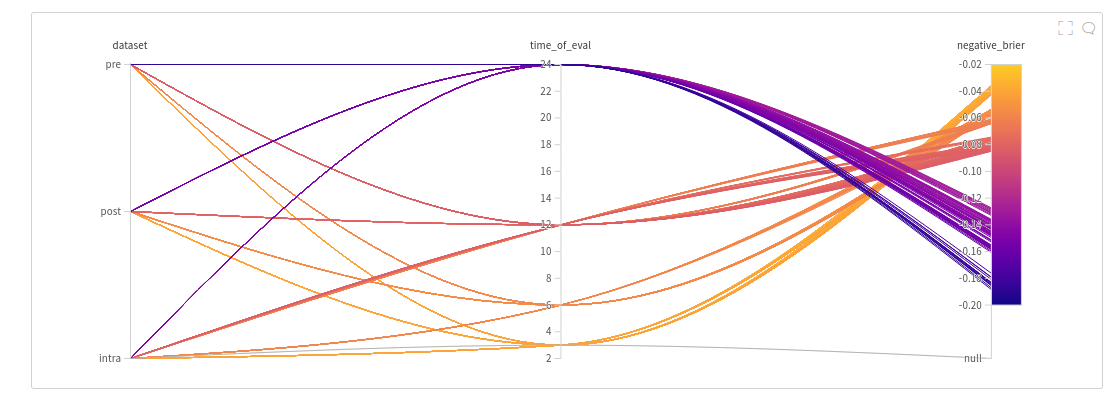

by the way, it's obvious from this plot that no matter the model, the time of prediction is the most important factor of prediction quality. 

## Feature Selection

We ran Recursive Feature Selection we implemented (sklearn's won't fit survival cencored data).
This function looks for feature scores with and without each of the k features, than greedly select the k-1 features for the next iteration.
The score it calculates is Integrated Brier Score on qeuried times. In our case, only one time of interest. 
IT TAKES A VERY LONG TIME TO COMPUTE! I will show an example on the dataset with only the aggragated features, as it contains only 65~ features instead of 110~ features, so it is lighter.  



best features using GBM on all times of interest
['weight', 'height', 'obesity', 'Liver involvment', 'RUQ', 'Epigastric', 'LUQ', 'LLQ', 'Low Jej', 'PCI', 'SPS', 'or_time', 'icu_stay_days', 'hospital_stay_days', 'reoperation', 'Patho % ', 'n specimens inv', 'N', 'scar_involvement', '5FU+ Leucovorin']



In [13]:
X_train_validation_only_aggs, X_test_only_aggs, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(get_df_for_stage('post',return_all_features=True,keep_only_aggs = True),seed = SEED)
intra_6_rsf_only_aggs = RandomSurvivalForest(n_estimators=1000, min_samples_split=10,min_samples_leaf=30)
#and lets add another gradient boosting for fun
intra_6_gbm_only_aggs = GradientBoostingSurvivalAnalysis(loss="coxph", learning_rate=0.05, n_estimators=1000,
                                           min_samples_split=5, min_samples_leaf=3, max_depth=3, random_state=0)

In [ ]:
best_20_features_intra_6_rsf_only_aggs = get_features_using_rfe(
    X_train_validation_only_aggs,y_train_validation,intra_6_rsf,times=6,n_features_to_keep=20)
best_20_features_intra_6_gbm_only_aggs = get_features_using_rfe(
    X_train_validation_only_aggs,y_train_validation,intra_6_gbm,times=6,n_features_to_keep=20)

len of current features: 66
len of current features: 65
len of current features: 64
len of current features: 63
len of current features: 62
len of current features: 61
len of current features: 60


In [ ]:
print('Best RSF_only_aggs Features for 6 months intra:')
print(best_20_features_intra_6_rsf_only_aggs)
print('Best GBM_only_aggs Features for 6 months intra:')
print(best_20_features_intra_6_gbm_only_aggs)
print('this are the mutual features:')
print(set(best_20_features_intra_6_gbm_only_aggs).intersection(set(best_20_features_intra_6_rsf_only_aggs)))

Now we will Use Weights and Biases to choose the best models on the val set.
We were carefull to use the same indices of this notebook's train and test to prevent leakage.
1. RSF brier val scores - 
2. GMB brier val scores - 


Becuase we don't want the user to insert all features, it's quite unclear how to select the best set of features to be used on all times.
We finally setteled for these set of features:

In [ ]:
stage = 'post'
time = 12
times = (3, 6, 12, 24)
df = get_df_for_stage(stage, return_all_features=True, keep_only_aggs=True)
X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(df, seed=0)
clf = GradientBoostingSurvivalAnalysis(loss="coxph", learning_rate=0.05, n_estimators=1000,
                                       min_samples_split=5, min_samples_leaf=3, max_depth=3, random_state=0)
print(f'{clf} feature elimination on {times}  months on {stage} dataset ')
best_features = get_features_using_rfe(X_train_validation, y_train_validation, model=clf, times=times,
                                       n_features_to_keep=20)
print(best_features)

In [12]:
# if restarted the kernel and you want to avoid the re-calculation
# best_features = ['weight', 'height', 'obesity', 'Liver involvment', 'RUQ', 'Epigastric', 'LUQ', 'LLQ', 'Low Jej', 'PCI', 'SPS', 'or_time', 'icu_stay_days', 'hospital_stay_days', 'reoperation', 'Patho % ', 'n specimens inv', 'N', 'scar_involvement', '5FU+ Leucovorin']

We used Recursive feature elimination with a GBM model, evaluated on all times of intereset (3,6,12,24 months) - on the aggragated dataset only. 
When we inspected the results we appriciated this set of features for two reasons:
1) They comply with the current domain knowledge - many of these features were marked as important before our study, e.g SPS, PCI, Liver Involvment...
2) They represented all of the times of intereset - The patient "base" physical state (age, weight), the operation itself which affects immidiate survival (operation time) and of course the disease state (PCI,SPS etc).
3) They reached relatively good scores.

It's possible a best set of features exists and it is recommended to keep researching this point further. 

## MODEL SELECTION

One of our first goals was to fit a model for each time of interest. Our reasoning was that different features are important for each time.
for example - The first 3 months are probably more affected by operation complications than the cancer itself.
After 12 months from operation, it's less likely (a-priori) to die from the operation itself, and cancer or other causes of disease are more releavnt.
Because of a lack of time, out application does not support this feature - we use only a single set of features, and a single model (because we found a set of hyperparameters that was good overall).

In this notebook we will show them both.

### Evaluation functions - startified negative brier and concordance

In [13]:
def get_stratified_cross_val_brier_scores(X_train_validation, y_train_validation, model, time):
    skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_index, validation_index in skf.split(X_train_validation, pd.DataFrame(y_train_validation)["death"]):
        X_train_fold, X_validation_fold = X_train_validation.iloc[train_index,:], X_train_validation.iloc[validation_index,:]
        y_train_fold, y_validation_fold = y_train_validation[train_index], y_train_validation[validation_index]
        clf = deepcopy(model)
        scorer = as_integrated_brier_score_scorer(estimator=clf, times=[time, time+0.001])
        scorer.fit(X_train_fold, y_train_fold)
        scores.append(scorer.score(X_validation_fold, y_validation_fold))
        average_negative_brier_score = np.mean(scores)
    return average_negative_brier_score


def get_stratified_concordance_scores(X_train_validation, y_train_validation, model, time):
    skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_index, validation_index in skf.split(X_train_validation, pd.DataFrame(y_train_validation)["death"]):
        X_train_fold, X_validation_fold = X_train_validation.iloc[train_index,:], X_train_validation.iloc[validation_index,:]
        y_train_fold, y_validation_fold = y_train_validation[train_index], y_train_validation[validation_index]
        clf = deepcopy(model)
        clf.fit(X_train_fold, y_train_fold)
        scores.append(clf.score(X_validation_fold, y_validation_fold))
        average_negative_brier_score = np.mean(scores)
    # print("concordance scores cross val", scores)
    return average_negative_brier_score

We used hyperparameter search.

we setteled for these two models: 

## Single model fitted on specific times

In [15]:
single_rsf_model = RandomSurvivalForest(min_samples_leaf=5, min_samples_split=20, n_estimators=100)
single_gbm_model = GradientBoostingSurvivalAnalysis(loss="coxph", learning_rate=0.05, n_estimators=1000,
                                           min_samples_split=5, min_samples_leaf=20, max_depth=5)


And our baseline model is a Cox model

In [19]:
# baseline_cox = CoxnetSurvivalAnalysis(l1_ratio = 1e-8, fit_baseline_model=True)
baseline_cox = CoxPHSurvivalAnalysis(alpha=0.0001)


#### Lets Test them!

In [20]:
rsf_tests = []
gbm_tests = []
cox_tests = []
for time in [3,6,12,24]:
    for stage in ['pre','post','intra']:
        stage_df = get_df_for_stage(stage,return_all_features = True, keep_only_aggs = True)
        X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(stage_df,seed = 0)
        X_train_validation = filter_df_columns_from_list(X_train_validation,best_features)
        X_test = filter_df_columns_from_list(X_test,best_features)
        
        rsf_eval_brier_score = get_stratified_cross_val_brier_scores(X_train_validation,y_train_validation,single_rsf_model,time)
        gbm_eval_brier_score = get_stratified_cross_val_brier_scores(X_train_validation,y_train_validation,single_gbm_model,time)
        cox_eval_brier_score = get_stratified_cross_val_brier_scores(X_train_validation,y_train_validation,baseline_cox,time)

        
        rsf_eval_c_score = get_stratified_concordance_scores(X_train_validation,y_train_validation,single_rsf_model,time)
        gbm_eval_c_score = get_stratified_concordance_scores(X_train_validation,y_train_validation,single_gbm_model,time)
        cox_eval_c_score = get_stratified_concordance_scores(X_train_validation,y_train_validation,baseline_cox,time)

        
        single_rsf_model.fit(X_train_validation,y_train_validation)
        rsf_test_c1_score = single_rsf_model.score(X_test,y_test)
        single_gbm_model.fit(X_train_validation,y_train_validation)
        gbm_test_c1_score = single_gbm_model.score(X_test,y_test)
        baseline_cox.fit(X_train_validation,y_train_validation)
        cox_test_c1_score = baseline_cox.score(X_test,y_test)
        
        rsf_scorer = as_integrated_brier_score_scorer(estimator=single_rsf_model, times=[time, time+0.001])
        rsf_scorer.fit(X_train_validation,y_train_validation)
        rsf_test_brier_score = np.abs(rsf_scorer.score(X_test, y_test))
        
        gbm_scorer = as_integrated_brier_score_scorer(estimator=single_gbm_model, times=[time, time+0.001])
        gbm_scorer.fit(X_train_validation,y_train_validation)
        gbm_test_brier_score = np.abs(gbm_scorer.score(X_test, y_test))
        
        cox_scorer = as_integrated_brier_score_scorer(estimator=baseline_cox, times=[time, time+0.001])
        cox_scorer.fit(X_train_validation,y_train_validation)
        cox_test_brier_score = np.abs(cox_scorer.score(X_test, y_test))
        
        rsf_tests.append({'time':time,'stage':stage,'brier_eval_score':rsf_eval_brier_score,'c-index eval':rsf_eval_c_score,'brier_test_score':rsf_test_brier_score,'c-index_test_score':rsf_test_c1_score})
        gbm_tests.append({'time':time,'stage':stage,'brier_eval_score':gbm_eval_brier_score,'c-index eval':gbm_eval_c_score,'brier_test_score':gbm_test_brier_score,'c-index_test_score':gbm_test_c1_score})
        cox_tests.append({'time':time,'stage':stage,'brier_eval_score':cox_eval_brier_score,'c-index eval':cox_eval_c_score,'brier_test_score':cox_test_brier_score,'c-index_test_score':cox_test_c1_score})

        

### RESULTS ANALYSIS

In [21]:
gbm_results = pd.DataFrame(gbm_tests)
gbm_results

,time,stage,brier_eval_score,c-index eval,brier_test_score,c-index_test_score
0,3,pre,-0.038085,0.364649,0.027209,0.463889
1,3,post,-0.036612,0.560562,0.023600,0.755556
2,3,intra,-0.035545,0.464475,0.023700,0.594444
3,6,pre,-0.057846,0.364649,0.058239,0.463889
4,6,post,-0.055190,0.560562,0.051872,0.755556
5,6,intra,-0.055742,0.464475,0.051407,0.594444
6,12,pre,-0.087175,0.364649,0.084686,0.463889
7,12,post,-0.082103,0.560562,0.079999,0.755556
8,12,intra,-0.082773,0.464475,0.074990,0.594444
9,24,pre,-0.166049,0.364649,0.221005,0.463889


In [22]:
rsf_results = pd.DataFrame(rsf_tests)
rsf_results

,time,stage,brier_eval_score,c-index eval,brier_test_score,c-index_test_score
0,3,pre,-0.037140,0.320967,0.023941,0.463889
1,3,post,-0.035223,0.649546,0.023508,0.733333
2,3,intra,-0.036438,0.416043,0.023267,0.644444
3,6,pre,-0.057029,0.309575,0.050803,0.497222
4,6,post,-0.051549,0.638693,0.050737,0.766667
5,6,intra,-0.056889,0.462550,0.048875,0.544444
6,12,pre,-0.082124,0.299813,0.074567,0.397222
7,12,post,-0.076466,0.641044,0.071461,0.772222
8,12,intra,-0.080838,0.449269,0.071183,0.633333
9,24,pre,-0.153549,0.282225,0.185944,0.602778


In [23]:
baseline_results = pd.DataFrame(cox_tests)
baseline_results

,time,stage,brier_eval_score,c-index eval,brier_test_score,c-index_test_score
0,3,pre,-0.036844,0.393043,0.023601,0.661111
1,3,post,-0.045232,0.583114,0.025432,0.622222
2,3,intra,-0.045032,0.436795,0.023683,0.622222
3,6,pre,-0.055549,0.393043,0.049770,0.661111
4,6,post,-0.059889,0.583114,0.058880,0.622222
5,6,intra,-0.068113,0.436795,0.051577,0.622222
6,12,pre,-0.081127,0.393043,0.074752,0.661111
7,12,post,-0.366395,0.583114,0.104185,0.622222
8,12,intra,-0.095944,0.436795,0.080972,0.622222
9,24,pre,-0.153633,0.393043,0.180220,0.661111


Plots plots plots

In [ ]:
import matplotlib.pyplot as plt

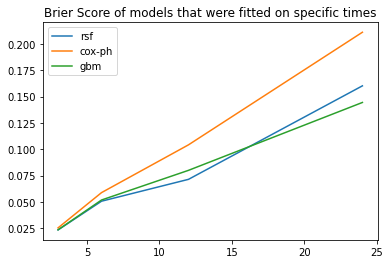

In [45]:
plt.plot([3,6,12,24],rsf_results[rsf_results['stage'] == 'post']['brier_test_score'],label='rsf')
plt.plot([3,6,12,24],baseline_results[baseline_results['stage'] == 'post']['brier_test_score'],label='cox-ph')
plt.plot([3,6,12,24],gbm_results[gbm_results['stage'] == 'post']['brier_test_score'],label='gbm')
plt.title('Brier Score of models that were fitted on specific times')
plt.legend()

We can see that ML models dominate Cox-PH by far.

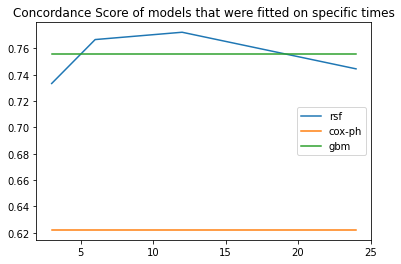

In [46]:
plt.plot([3,6,12,24],rsf_results[rsf_results['stage'] == 'post']['c-index_test_score'],label='rsf')
plt.plot([3,6,12,24],baseline_results[baseline_results['stage'] == 'post']['c-index_test_score'],label='cox-ph')
plt.plot([3,6,12,24],gbm_results[gbm_results['stage'] == 'post']['c-index_test_score'],label='gbm')
plt.title('Concordance Score of models that were fitted on specific times')
plt.legend()

## A Model for each time

We've disscussed how creating a different model for each time of interest should be beneficial. 
We can approach this goal in two ways:
1) Searching for hyperparameters for each times
2) Searching for hyperparameters AND different features for each time

we will focus on Random Survival Forest as it gives consistent better results.
This is going to be computationally expensive, lets go. 

### Hyperparameters search

In [73]:
rsf_model = RandomSurvivalForest()
rsf_hyperparameters_tests = []
rsf_tuned_models = {}
best_overall_features = ['weight', 'height', 'obesity', 'Liver involvment', 'RUQ', 'Epigastric', 'LUQ', 'LLQ', 'Low Jej', 'PCI', 'SPS', 'or_time', 'icu_stay_days', 'hospital_stay_days', 'reoperation', 'Patho % ', 'n specimens inv', 'N', 'scar_involvement', '5FU+ Leucovorin']
for time in [3,6,12,24]:
    for stage in ['pre','post','intra']:

        stage_df = get_df_for_stage(stage,return_all_features = True, keep_only_aggs = True)
        X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(stage_df,seed = 0)
        
        
        
        X_train_validation = filter_df_columns_from_list(X_train_validation,best_features)
        X_test = filter_df_columns_from_list(X_test,best_features)
        
        rsf_scorer = as_integrated_brier_score_scorer(rsf_model,times=[time,time+0.001])
        
        cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
        splitter = cv.split(X_train_validation,y_train_validation['death'])
        
        # for debug
        # params_to_search = {'estimator__n_estimators':[100],'estimator__min_samples_leaf':[3],'estimator__min_samples_split':[5]}

        params_to_search = {'estimator__n_estimators':[100,250,500,1000],'estimator__min_samples_leaf':[3,5,10,20,30],'estimator__min_samples_split':[5,10,15,20]}
        grid_search = GridSearchCV(estimator=rsf_scorer,param_grid=params_to_search,n_jobs=-1,cv = splitter).fit(X_train_validation,y_train_validation)

        rsf_eval_brier_score = grid_search.best_score_
        rsf_test_brier_score = grid_search.best_estimator_.score(X_test,y_test)

        for key in grid_search.best_params_.keys():
            grid_search.best_params_[key[len('estimator__'):]] = grid_search.best_params_.pop(key)

        c_index_rsf_model = RandomSurvivalForest(**grid_search.best_params_)
        c_index_rsf_model.fit(X_train_validation,y_train_validation)
        rsf_test_c1_score = c_index_rsf_model.score(X_test,y_test)
        
        rsf_hyperparameters_tests.append({'time':time,'stage':stage,'brier_eval_score':rsf_eval_brier_score,'brier_test_score':rsf_test_brier_score,'c-index_test_score':rsf_test_c1_score})
        rsf_tuned_models.update({f'{time}_{stage}':grid_search.best_estimator_})
        

In [35]:
rsf_hyperparams_tests = pd.DataFrame(rsf_hyperparameters_tests)
rsf_hyperparams_tests

,time,stage,brier_eval_score,brier_test_score,c-index_test_score
0,3,pre,-0.036258,-0.023667,0.513889
1,3,post,-0.034242,-0.024018,0.755556
2,3,intra,-0.035885,-0.022953,0.688889
3,6,pre,-0.055175,-0.050380,0.438889
4,6,post,-0.050841,-0.052124,0.772222
5,6,intra,-0.054685,-0.048958,0.655556
6,12,pre,-0.078734,-0.074763,0.444444
7,12,post,-0.075821,-0.070229,0.783333
8,12,intra,-0.078502,-0.072435,0.705556
9,24,pre,-0.148519,-0.183427,0.500000


### HyperParameters + features search

In [36]:
rsf_model = RandomSurvivalForest(n_estimators=100,min_samples_leaf=20,min_samples_split=30)
rsf_hyperparameters_and_features_tests = []

cox_check = CoxPHSurvivalAnalysis(alpha=0.0001)
cox_hyperparams_and_feature_tests = []
for time in [3,6,12,24]:
    for stage in ['pre','post','intra']:
        print(f'stage {stage}, time: {time}')
        stage_df = get_df_for_stage(stage,return_all_features = True, keep_only_aggs = True)
        X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(stage_df,seed = 0)
        best_features = get_features_using_rfe(X_train_validation, y_train_validation, model=rsf_model, times=[time,time+0.001],
                                       n_features_to_keep=20)
        X_train_validation = filter_df_columns_from_list(X_train_validation,best_features)
        
        
        
        X_test = filter_df_columns_from_list(X_test,best_features)
        
        rsf_scorer = as_integrated_brier_score_scorer(rsf_model,times=[time,time+0.001])
        
        cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
        splitter = cv.split(X_train_validation,y_train_validation['death'])
        
        # for debug
        # params_to_search = {'estimator__n_estimators':[100],'estimator__min_samples_leaf':[3],'estimator__min_samples_split':[5]}

        params_to_search = {'estimator__n_estimators':[100,250,500,1000],'estimator__min_samples_leaf':[3,5,10,20,30],'estimator__min_samples_split':[5,10,15,20]}
        grid_search = GridSearchCV(estimator=rsf_scorer,param_grid=params_to_search,n_jobs=-1,cv = splitter).fit(X_train_validation,y_train_validation)

        rsf_eval_brier_score = grid_search.best_score_
        rsf_test_brier_score = grid_search.best_estimator_.score(X_test,y_test)

        for key in grid_search.best_params_.keys():
            grid_search.best_params_[key[len('estimator__'):]] = grid_search.best_params_.pop(key)

        c_index_rsf_model = RandomSurvivalForest(**grid_search.best_params_)
        c_index_rsf_model.fit(X_train_validation,y_train_validation)
        rsf_test_c1_score = c_index_rsf_model.score(X_test,y_test)
        
        rsf_hyperparameters_and_features_tests.append({'time':time,'stage':stage,'brier_eval_score':rsf_eval_brier_score,'brier_test_score':rsf_test_brier_score,
                                                       'c-index_test_score':rsf_test_c1_score,'features_used':best_features})
        rsf_model = c_index_rsf_model
        

stage pre, time: 3
stage post, time: 3
len of current features: 66
len of current features: 65
len of current features: 64
len of current features: 63
len of current features: 62
len of current features: 61
len of current features: 60
len of current features: 59
len of current features: 58
len of current features: 57
len of current features: 56
len of current features: 55
len of current features: 54
len of current features: 53
len of current features: 52
len of current features: 51
len of current features: 50
len of current features: 49
len of current features: 48
len of current features: 47
len of current features: 46
len of current features: 45
len of current features: 44
len of current features: 43
len of current features: 42
len of current features: 41
len of current features: 40
len of current features: 39
len of current features: 38
len of current features: 37
len of current features: 36
len of current features: 35
len of current features: 34
len of current features: 33
len of cu

In [37]:
final_df = pd.DataFrame(rsf_hyperparameters_and_features_tests)
final_df

,time,stage,brier_eval_score,brier_test_score,c-index_test_score,features_used
0,3,pre,-0.036069,-0.024097,0.377778,"[age, gender, weight, height, BMI, DM, HTN, Re..."
1,3,post,-0.036676,-0.023673,0.711111,"[height, BMI, DM, IHD, COPD, Rt (1) Lt (0), Ce..."
2,3,intra,-0.036438,-0.023727,0.705556,"[height, BMI, DM, COPD, obesity, Cva, redo_hip..."
3,6,pre,-0.054456,-0.051636,0.361111,"[age, gender, weight, height, BMI, DM, HTN, Re..."
4,6,post,-0.051299,-0.053952,0.700000,"[height, DM, asa, extra_peritoneal___none, asc..."
5,6,intra,-0.054847,-0.050447,0.622222,"[gender, height, DM, HTN, IHD, COPD, obesity, ..."
6,12,pre,-0.078856,-0.078328,0.361111,"[age, gender, weight, height, BMI, DM, HTN, Re..."
7,12,post,-0.077755,-0.071639,0.494444,"[height, BMI, IHD, obesity, Cva, ascites_drain..."
8,12,intra,-0.078735,-0.073029,0.716667,"[height, BMI, Renal, IHD, obesity, Cva, hipec_..."
9,24,pre,-0.148912,-0.184018,0.377778,"[age, gender, weight, height, BMI, DM, HTN, Re..."


Text(0.5, 1.0, 'Brier Score of single fitted models VS time-specific models')

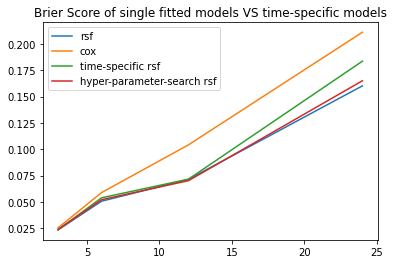

In [87]:

plt.plot([3,6,12,24],rsf_results[rsf_results['stage'] == 'post']['brier_test_score'],label='rsf')
plt.plot([3,6,12,24],baseline_results[baseline_results['stage'] == 'post']['brier_test_score'],label='cox')
plt.plot([3,6,12,24],np.abs(final_df[final_df['stage'] == 'post']['brier_test_score']),label = 'time-specific rsf')
plt.plot([3,6,12,24],np.abs(rsf_hyperparams_tests[rsf_hyperparams_tests['stage'] == 'post']['brier_test_score']),label = 'hyper-parameter-search rsf')
plt.legend()
plt.title('Brier Score of single fitted models VS time-specific models')

Text(0.5, 1.0, 'Concordance Score of single fitted models VS time-specific models')

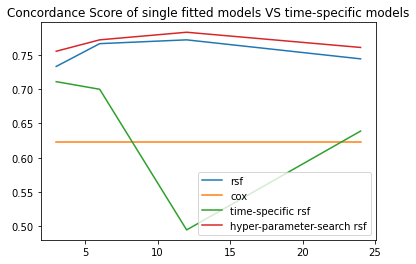

In [86]:
plt.plot([3,6,12,24],rsf_results[rsf_results['stage'] == 'post']['c-index_test_score'],label='rsf')
plt.plot([3,6,12,24],baseline_results[baseline_results['stage'] == 'post']['c-index_test_score'],label='cox')
plt.plot([3,6,12,24],np.abs(final_df[final_df['stage'] == 'post']['c-index_test_score']),label = 'time-specific rsf')
plt.plot([3,6,12,24],np.abs(rsf_hyperparams_tests[rsf_hyperparams_tests['stage'] == 'post']['c-index_test_score']),label = 'hyper-parameter-search rsf')

plt.legend()
plt.title('Concordance Score of single fitted models VS time-specific models')

Lets check if cox with feature selection gives similiar results

In [40]:
cox_model = CoxnetSurvivalAnalysis(l1_ratio = 1e-8, fit_baseline_model=True)
cox_hyperparameters_and_features_tests = []


for time in [3,6,12,24]:
    for stage in ['pre','post','intra']:
        print(f'stage {stage}, time: {time}')
        stage_df = get_df_for_stage(stage,return_all_features = True, keep_only_aggs = True)
        X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(stage_df,seed = 0)
        best_features = get_features_using_rfe(X_train_validation, y_train_validation, model=cox_model, times=[time,time+0.001],
                                       n_features_to_keep=20)
        X_train_validation = filter_df_columns_from_list(X_train_validation,best_features)
        
        
        
        X_test = filter_df_columns_from_list(X_test,best_features)
        
        cox_scorer = as_integrated_brier_score_scorer(cox_model,times=[time,time+0.001])
        cox_scorer.fit(X_train_validation,y_train_validation)
        cox_test_brier = cox_scorer.score(X_test,y_test)
        


        
        cox_hyperparameters_and_features_tests.append({'time':time,'stage':stage,'brier_test_score':cox_test_brier,
                                                       'features_used':best_features})
        

stage pre, time: 3
stage post, time: 3
len of current features: 66
len of current features: 65
len of current features: 64
len of current features: 63
len of current features: 62
len of current features: 61
len of current features: 60
len of current features: 59
len of current features: 58
len of current features: 57
len of current features: 56
len of current features: 55
len of current features: 54
len of current features: 53
len of current features: 52
len of current features: 51
len of current features: 50
len of current features: 49
len of current features: 48
len of current features: 47
len of current features: 46
len of current features: 45
len of current features: 44
len of current features: 43
len of current features: 42
len of current features: 41
len of current features: 40
len of current features: 39
len of current features: 38
len of current features: 37
len of current features: 36
len of current features: 35
len of current features: 34
len of current features: 33
len of cu

In [41]:
cox_check_df = pd.DataFrame(cox_hyperparameters_and_features_tests)

Text(0.5, 1.0, 'Time specific Cox VS time specific RSF')

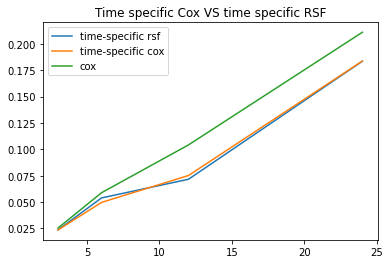

In [52]:
plt.plot([3,6,12,24],np.abs(final_df[final_df['stage'] == 'post']['brier_test_score']),label = 'time-specific rsf')
plt.plot([3,6,12,24],np.abs(cox_check_df[cox_check_df['stage'] == 'post']['brier_test_score']),label = 'time-specific cox')
plt.plot([3,6,12,24],baseline_results[baseline_results['stage'] == 'post']['brier_test_score'],label='cox')
plt.legend()
plt.title('Time specific Cox VS time specific RSF')

## Lets check feature importances using Permutation Importance

We checked Feature importance on all features (witout feature selection step), and later - using feature selection. 

In [148]:
import eli5
from eli5.sklearn import PermutationImportance
results = []
stage = 'post'
time = 12 
for time in [3,6,12,24]:
    stage_df = get_df_for_stage(stage,return_all_features = True, keep_only_aggs = True)
    X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(stage_df,seed = 0)
    X = pd.concat([X_train_validation, X_test])
    y = np.concatenate((y_train_validation, y_test), axis=0)
    rsf_scorer = as_integrated_brier_score_scorer(rsf_model,times = [time,time+0.001])
    rsf_scorer.fit(X,y)
    perm = PermutationImportance(rsf_scorer, n_iter=30, random_state=24652)
    perm.fit(X, y)
    results.append(perm.feature_importances_)


In [149]:
pd.DataFrame(pd.DataFrame(results).apply(np.mean,axis=0)).set_index(X.columns).sort_values(by=0,ascending=False).head(15)

,0
Patho %,0.005107
reoperation,0.005005
n specimens inv,0.004808
hospital_stay_days,0.004103
Pelvic Peritonectomy,0.003695
PCI,0.003318
resections_count,0.002940
complications_count,0.002633
n specimens sub,0.002179
weight,0.002102


With feature selection

In [ ]:
best_overall_features

In [147]:
feature_selection_results = []
for time in [3,6,12,24]:
    stage_df = get_df_for_stage(stage,return_all_features = True, keep_only_aggs = True)
    X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(stage_df,seed = 0)
    X_train_validation= filter_df_columns_from_list(X_train_validation,best_overall_features)
    X_test= filter_df_columns_from_list(X_test,best_overall_features)
    X = pd.concat([X_train_validation, X_test])
    y = np.concatenate((y_train_validation, y_test), axis=0)
    rsf_scorer = as_integrated_brier_score_scorer(rsf_model,times = [time,time+0.001])
    rsf_scorer.fit(X,y)
    perm = PermutationImportance(rsf_scorer, n_iter=30, random_state=24652)
    perm.fit(X, y)
    feature_selection_results.append(perm.feature_importances_)


,0
n specimens inv,0.010170
Patho %,0.008996
hospital_stay_days,0.008825
PCI,0.007383
reoperation,0.007310
height,0.004144
weight,0.003973
or_time,0.003530
LLQ,0.002138
N,0.002028


In [151]:
stage_df = get_df_for_stage(stage,return_all_features = True, keep_only_aggs = True)
X_train_validation, X_test, y_train_validation, y_test = impute_nan_values_and_split_to_train_test(stage_df,seed = 0)
X_train_validation= filter_df_columns_from_list(X_train_validation,best_overall_features)
X_test= filter_df_columns_from_list(X_test,best_overall_features)
X_feature_selection = pd.concat([X_train_validation, X_test])
y_feature_selection = np.concatenate((y_train_validation, y_test), axis=0)

In [152]:
pd.DataFrame(pd.DataFrame(feature_selection_results).apply(np.mean,axis=0)).set_index(X_feature_selection.columns).sort_values(by=0,ascending=False).head(15)

,0
n specimens inv,0.010170
Patho %,0.008996
hospital_stay_days,0.008825
PCI,0.007383
reoperation,0.007310
height,0.004144
weight,0.003973
or_time,0.003530
LLQ,0.002138
N,0.002028


We can see that some of the features keep coming back! n_specimens, Patho %, PCI, Hospital stay days...
Interesting!